In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from os.path import basename, join
import glob
from matplotlib import pyplot as plt
import mediapipe as mp
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score
import sklearn.svm as svm
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert color to RGB
    image.flags.writeable = False                  
    res = model.process(RGB)                 # Make prediction
    image.flags.writeable = True                   
    BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # convert color back to BGR
    return BGR, res

In [4]:
#get keypoints of left hand and right hand and pose
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [5]:
def get_lists(folder):
    name_list = []
    path_list = []
    label = []
    num = 0
    for i in glob.glob(join(folder, '*')):
        name_list.append(basename(i))
        for j in glob.glob(join(i, '*.mp4')):
            path_list.append(j)
            label.append(num)
        num = num+1
    return name_list, path_list, label

In [6]:
def frame_select(frames):
    result_frames = []
    for i in range(20):
        index = (i+1)*int(len(frames)/21)
        result_frames.append(frames[index])
    return result_frames

In [7]:
def read_data(path_list):
    data = []
    for path in path_list:
        cap = cv2.VideoCapture(path)
        frames = 0
        #select 20 frames, every frame has 258 keypoints
        color_df = np.zeros((20,258))
        index = 0

        # Set mediapipe model
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            while cap.isOpened() and index<=19:
                # Read feed
                ret, frame = cap.read()
                if not ret:
                    break
                if frames%6 == 0:
                    # Make detections
                    image, results = mediapipe_detection(frame, holistic)
                    #print(results)
                    keypoints = extract_keypoints(results)
                    color_df[index,:] = keypoints
                    index+=1
                frames +=1
        
        #padding,if the video is less than 20 frame, use the last one frame to pad for the rest
        if index <19:
            color_df[index:,:] = color_df[index-1,:]
        data.append(color_df)
    print('extraction of key points completed')
    return np.array(data)

In [8]:
name_list, path_list, label = get_lists(r'D:\coursera\video\788 nerual\dataset\project\new_self_data')
data = read_data(path_list)
print(data.shape)

extraction of key points completed
(344, 20, 258)


In [9]:
#Normalization
def scalers(data):
    new_data = data
    mms = MinMaxScaler(feature_range = (0,1))
    for i in range(new_data.shape[0]):
        new_data[i, :, :] = mms.fit_transform(new_data[i, :, :])

    return new_data

In [10]:
#Normalize the data
or_data = scalers(data)
label = np.array(label)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(or_data, label, test_size=0.1,random_state=9)


In [12]:
print(y_train.shape)
print(y_test.shape)

(309,)
(35,)


In [13]:
#Reshape the data to 2 dimension Since SVM can't accept three dimension.
Newtrain_x = (x_train.reshape(x_train.shape[0], -1))
Newtest_x = (x_test.reshape(x_test.shape[0], -1))
print(Newtrain_x.shape)
print(Newtest_x.shape)

(309, 5160)
(35, 5160)


In [14]:
def svc(kernel):
    return svm.SVC(kernel=kernel, decision_function_shape="ovo")


def nusvc():
    return svm.NuSVC(decision_function_shape="ovo")


def modelist():
    #append different kernel for svc
    modelist = []
    kernalist = ["linear", "poly", "sigmoid", "rbf"]
    for each in kernalist:
        modelist.append(svc(each))
    modelist.append(nusvc())
    return modelist


def svc_model(model):
    #return the result
    model.fit(Newtrain_x, y_train)
    acu_train = model.score(Newtrain_x, y_train)
    acu_test = model.score(Newtest_x, y_test)
    y_pred = model.predict(Newtest_x)
    recall = recall_score(y_test, y_pred, average="macro")
    f1score = f1_score(y_test, y_pred, average="macro")
    return acu_train, acu_test, recall, f1score

def run_svc_model(modelist):
    result = {"kernel": [],
              "acu_train": [],
              "acu_test": [],
              "recall": [],
              "F1_score":[]
              }

    for model in modelist:
        acu_train, acu_test, recall,f1score = svc_model(model)
        try:
            result["kernel"].append(model.kernel)
        except:
            result["kernel"].append('Non')
        result["acu_train"].append(acu_train)
        result["acu_test"].append(acu_test)
        result["recall"].append(recall)
        result["F1_score"].append(f1score)

    return pd.DataFrame(result)


In [15]:
model_list = modelist()
print(model_list)
res = run_svc_model(modelist())

[SVC(decision_function_shape='ovo', kernel='linear'), SVC(decision_function_shape='ovo', kernel='poly'), SVC(decision_function_shape='ovo', kernel='sigmoid'), SVC(decision_function_shape='ovo'), NuSVC(decision_function_shape='ovo')]


C:\Users\53292\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\53292\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\53292\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\53292\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is 

In [16]:
res.insert(0,'type',['svc','svc','svc','svc','nusvc'])
res

,type,kernel,acu_train,acu_test,recall,F1_score
0,svc,linear,1.000000,0.885714,0.831250,0.811508
1,svc,poly,1.000000,0.885714,0.831250,0.811508
2,svc,sigmoid,0.362460,0.200000,0.262500,0.166071
3,svc,rbf,0.987055,0.857143,0.815625,0.789335
4,nusvc,rbf,0.964401,0.857143,0.815625,0.789335


In [17]:
def svc_rbf(temp_c):
    train = []
    test = []
    c = []
    for i in range(1,temp_c):
        modell = svm.SVC(C=i,kernel='linear', decision_function_shape="ovo")
        modell.fit(Newtrain_x, y_train)
        acu_train = modell.score(Newtrain_x, y_train)
        acu_test = modell.score(Newtest_x, y_test)
        c.append(i)
        train.append(acu_train)
        test.append(acu_test)
    return c,train,test
        

c_list, train_list, test_list = svc_rbf(20)
    

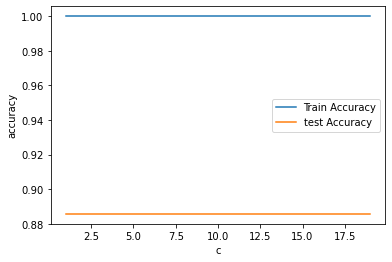

In [18]:
def plot_history(c_list, train_list, test_list):
    plt.figure()
    plt.xlabel('c')
    plt.ylabel('accuracy')
    plt.plot(c_list, train_list, label='Train Accuracy')
    plt.plot(c_list, test_list, label='test Accuracy')
    plt.legend()
    

plot_history(c_list, train_list, test_list)